# VGG16 fine-tuning for defect detection

This section builds a VGG16 model with ImageNet weights, lets you choose any valid input shape (HxWx3), and fine-tune only the last layers you specify.

In [2]:
import os
import sys
import datetime

import pickle
import numpy as np
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.defect_detection_models.VGG16_model import FineTunedVGG16
from SRModels.loading_methods import load_defects_dataset_as_patches
from SRModels.constants import VGG_PATCH_SIZE, VGG_STRIDE, RANDOM_SEED

In [3]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
CLASS_LABELS_PATH = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/class_labels_map.pkl"))

In [4]:
# X ->  High-resolution patches (model input)
# y -> Class labels (target)
X, y = load_defects_dataset_as_patches(HR_ROOT, patch_size=VGG_PATCH_SIZE, stride=VGG_STRIDE, class_map_path=CLASS_LABELS_PATH)

X = X[:int(len(X) * 0.7)]
y = y[:int(len(y) * 0.7)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

In [5]:
print(f"X shape: {X.shape}, Y shape: {y.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

unique, counts = np.unique(y, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

X shape: (14022, 96, 96, 3), Y shape: (14022,)
X_train shape: (10095, 96, 96, 3), y_train shape: (10095,)
X_val shape: (1122, 96, 96, 3), y_val shape: (1122,)
X_test shape: (2805, 96, 96, 3), y_test shape: (2805,)
Class distribution: {0: 5446, 1: 8576}


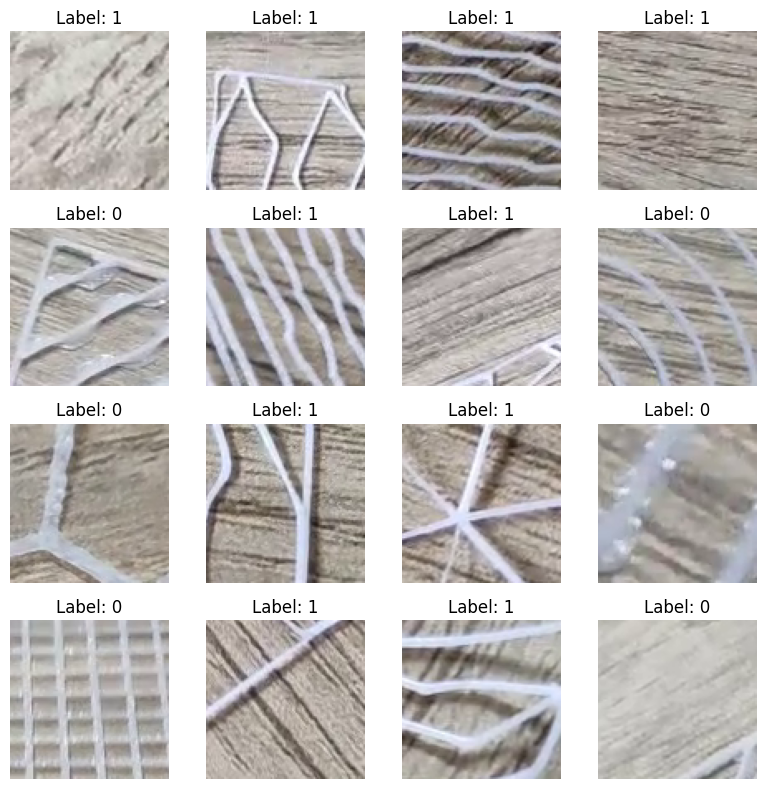

In [6]:
# Show a 4x4 grid of random patches from the training set with their labels
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for ax in axes.flatten():
    idx = np.random.randint(0, len(X_train))
    ax.imshow(X_train[idx])
    ax.set_title(f"Label: {y_train[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
model = FineTunedVGG16()

model.setup_model(
    input_shape=X.shape[1:],
    num_classes=np.unique(y).shape[0],
    train_last_n_layers=6,
    base_trainable=True,
    dropout_rate=0.3,
    l2_reg=1e-4,
    learning_rate=1e-3,
    loss="sparse_categorical_crossentropy",
    from_pretrained=False,
    pretrained_path=None
)

Model: "vgg16_finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                    

In [6]:
history = model.fit(
    X_train, y_train,
    X_val, y_val,
    batch_size=32,
    epochs=150,
    use_augmentation=True
)

Epoch 1/150
316/316 [==============================] - 18s 41ms/step - loss: 0.3994 - accuracy: 0.8268 - val_loss: 0.2869 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 2/150
316/316 [==============================] - 11s 36ms/step - loss: 0.3491 - accuracy: 0.8527 - val_loss: 0.2679 - val_accuracy: 0.8913 - lr: 0.0010
Epoch 3/150
316/316 [==============================] - 11s 35ms/step - loss: 0.3295 - accuracy: 0.8635 - val_loss: 0.2876 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/150
316/316 [==============================] - 11s 36ms/step - loss: 0.3194 - accuracy: 0.8690 - val_loss: 0.2568 - val_accuracy: 0.8886 - lr: 0.0010
Epoch 5/150
316/316 [==============================] - 12s 37ms/step - loss: 0.3096 - accuracy: 0.8726 - val_loss: 0.2529 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 6/150
316/316 [==============================] - 12s 37ms/step - loss: 0.3092 - accuracy: 0.8724 - val_loss: 0.2726 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 7/150
316/316 [==============================]

In [8]:
model.evaluate(X_test, y_test)

# Evaluate and prepare metrics dictionary
results = model.evaluate(X_test, y_test)

# Extract last epoch train/val metrics from history
train_loss = history.history['loss'] if 'loss' in history.history else None
val_loss = history.history['val_loss'] if 'val_loss' in history.history else None
train_accuracy = history.history['accuracy'] if 'accuracy' in history.history else None
val_accuracy = history.history['val_accuracy'] if 'val_accuracy' in history.history else None

metrics_dict = {
    "eval_loss": float(results[0]),
    "eval_accuracy": float(results[1]),
    "final_train_loss": train_loss,
    "final_val_loss": val_loss,
    "final_train_accuracy": train_accuracy,
    "final_val_accuracy": val_accuracy,
}

88/88 [==============================] - 2s 22ms/step - loss: 0.2029 - accuracy: 0.9205
Loss: 0.2029, Accuracy: 0.9205
88/88 [==============================] - 2s 20ms/step - loss: 0.2029 - accuracy: 0.9205
Loss: 0.2029, Accuracy: 0.9205


In [9]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

model.save(directory=f"models/VGG16/VGG16_{timestamp}", timestamp=timestamp)

Model saved to models/VGG16/VGG16_20250910_015040\VGG16_20250910_015040.h5


In [10]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/VGG16/VGG16_{timestamp}/VGG16_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\defect_detection_models\models\VGG16\VGG16_20250910_015040\VGG16_20250910_015040_metrics.pkl
